In [351]:
# Importing the necessary libraries

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import statsmodels.api as sm

In [352]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [353]:
# Importing Configs
# Define the path where config.py is located
# Mac
os.chdir("/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling")
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

# Configs
finbert_models = config.finbert_models
Body = config.Body
database = config.Local_Database

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [354]:
sentiment = pd.date_range(start="1/1/1990", end="1/1/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

Body = "Fed"

state = pd.read_csv(
    f"{finbert_models}/{Body}/Statements/{Body}_Statements_finbert_model_short.csv"
)
state = state[["date", "sentiment"]]
state = state.rename(columns={"sentiment": "statement_sentiment"})
state["date"] = pd.to_datetime(state["date"])

state = state.resample("Q", on="date").mean().reset_index()

filter_df = state.copy(deep=True)
filter_df = filter_df[["date", "statement_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["statement_sentiment"], 1600)

filter_df["statement_sentiment_cycle"] = cycle
filter_df["statement_sentiment_trend"] = trend

filter_df = filter_df[["date", "statement_sentiment_cycle"]]
state = state.drop(columns=["statement_sentiment"])
filter_df = filter_df.rename(
    columns={"statement_sentiment_cycle": "statement_sentiment"}
)
state = pd.merge(state, filter_df, on="date", how="left")
state = state.groupby("date").mean().reset_index()
sentiment = pd.merge(sentiment, state, how="left", left_on="date", right_on="date")

In [355]:
minutes = pd.read_csv(
    f"{finbert_models}/{Body}/Minutes/{Body}_Minutes_finbert_model_short.csv"
)
minutes = minutes[["date", "sentiment"]]
minutes = minutes.rename(columns={"sentiment": "minute_sentiment"})
minutes["date"] = pd.to_datetime(minutes["date"])

minutes = minutes.resample("Q", on="date").mean().reset_index()

filter_df = minutes.copy(deep=True)
filter_df = filter_df[["date", "minute_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["minute_sentiment"], 1600)

filter_df["minute_sentiment_cycle"] = cycle
filter_df["minute_sentiment_trend"] = trend

filter_df = filter_df[["date", "minute_sentiment_cycle"]]
minutes = minutes.drop(columns=["minute_sentiment"])
filter_df = filter_df.rename(columns={"minute_sentiment_cycle": "minute_sentiment"})
minutes = pd.merge(minutes, filter_df, on="date", how="left")
minutes = minutes.groupby("date").mean().reset_index()
sentiment = pd.merge(sentiment, minutes, how="left", left_on="date", right_on="date")

In [356]:
beigebook = pd.read_csv(
    f"{finbert_models}/{Body}/Beige Book/{Body}_Beige Book_finbert_model_short.csv"
)

beigebook = beigebook[["date", "sentiment"]]
beigebook = beigebook.rename(columns={"sentiment": "beigebook_sentiment"})
beigebook["date"] = pd.to_datetime(beigebook["date"])

beigebook = beigebook.resample("Q", on="date").mean().reset_index()

filter_df = beigebook.copy(deep=True)
filter_df = filter_df[["date", "beigebook_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["beigebook_sentiment"], 1600)

filter_df["beigebook_sentiment_cycle"] = cycle
filter_df["beigebook_sentiment_trend"] = trend

filter_df = filter_df[["date", "beigebook_sentiment_cycle"]]
beigebook = beigebook.drop(columns=["beigebook_sentiment"])
filter_df = filter_df.rename(
    columns={"beigebook_sentiment_cycle": "beigebook_sentiment"}
)
beigebook = pd.merge(beigebook, filter_df, on="date", how="left")
beigebook = beigebook.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, beigebook, how="left", left_on="date", right_on="date")

In [357]:
fed_speech = pd.read_csv(
    f"{finbert_models}/{Body}/Speeches/{Body}_Speeches_finbert_model_short.csv"
)
fed_speech = fed_speech[["date", "sentiment"]]
fed_speech = fed_speech.rename(columns={"sentiment": "fed_speech_sentiment"})
fed_speech["date"] = pd.to_datetime(fed_speech["date"])

fed_speech = fed_speech.resample("Q", on="date").mean().reset_index()

filter_df = fed_speech.copy(deep=True)
filter_df = filter_df[["date", "fed_speech_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["fed_speech_sentiment"], 1600)

filter_df["fed_speech_sentiment_cycle"] = cycle
filter_df["fed_speech_sentiment_trend"] = trend

filter_df = filter_df[["date", "fed_speech_sentiment_cycle"]]
fed_speech = fed_speech.drop(columns=["fed_speech_sentiment"])
filter_df = filter_df.rename(
    columns={"fed_speech_sentiment_cycle": "fed_speech_sentiment"}
)
fed_speech = pd.merge(fed_speech, filter_df, on="date", how="left")
fed_speech = fed_speech.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, fed_speech, how="left", left_on="date", right_on="date")

In [358]:
Body = "ECB"
mpd = pd.read_csv(
    f"{finbert_models}/{Body}/Monetary policy decisions/{Body}_Monetary policy decisions_finbert_model_short.csv"
)
mpd = mpd[["date", "sentiment"]]
mpd = mpd.rename(columns={"sentiment": "mpd_sentiment"})

mpd["date"] = pd.to_datetime(mpd["date"])

mpd = mpd.resample("Q", on="date").mean().reset_index()

filter_df = mpd.copy(deep=True)
filter_df = filter_df[["date", "mpd_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["mpd_sentiment"], 1600)

filter_df["mpd_sentiment_cycle"] = cycle
filter_df["mpd_sentiment_trend"] = trend

filter_df = filter_df[["date", "mpd_sentiment_cycle"]]
mpd = mpd.drop(columns=["mpd_sentiment"])
filter_df = filter_df.rename(columns={"mpd_sentiment_cycle": "mpd_sentiment"})
mpd = pd.merge(mpd, filter_df, on="date", how="left")
mpd = mpd.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, mpd, how="left", left_on="date", right_on="date")

In [359]:
pc = pd.read_csv(
    f"{finbert_models}/{Body}/Press Conferences/{Body}_Press Conferences_finbert_model_short.csv"
)
pc = pc[["date", "sentiment"]]
pc = pc.rename(columns={"sentiment": "pc_sentiment"})
pc["date"] = pd.to_datetime(pc["date"])

pc = pc.resample("Q", on="date").mean().reset_index()

filter_df = pc.copy(deep=True)
filter_df = filter_df[["date", "pc_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["pc_sentiment"], 1600)

filter_df["pc_sentiment_cycle"] = cycle
filter_df["pc_sentiment_trend"] = trend

filter_df = filter_df[["date", "pc_sentiment_cycle"]]
pc = pc.drop(columns=["pc_sentiment"])
filter_df = filter_df.rename(columns={"pc_sentiment_cycle": "pc_sentiment"})
pc = pd.merge(pc, filter_df, on="date", how="left")
pc = pc.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, pc, how="left", left_on="date", right_on="date")

In [360]:
eb = pd.read_csv(
    f"{finbert_models}/{Body}/Economic Bulletin/{Body}_Economic Bulletin_finbert_model_short.csv"
)
eb = eb[["date", "sentiment"]]
eb = eb.rename(columns={"sentiment": "eb_sentiment"})
eb["date"] = pd.to_datetime(eb["date"])

eb = eb.resample("Q", on="date").mean().reset_index()

filter_df = eb.copy(deep=True)
filter_df = filter_df[["date", "eb_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["eb_sentiment"], 1600)

filter_df["eb_sentiment_cycle"] = cycle
filter_df["eb_sentiment_trend"] = trend

filter_df = filter_df[["date", "eb_sentiment_cycle"]]
eb = eb.drop(columns=["eb_sentiment"])
filter_df = filter_df.rename(columns={"eb_sentiment_cycle": "eb_sentiment"})
eb = pd.merge(eb, filter_df, on="date", how="left")
eb = eb.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, eb, how="left", left_on="date", right_on="date")

In [361]:
ecb_speech = pd.read_csv(
    f"{finbert_models}/{Body}/Speeches/{Body}_Speeches_finbert_model_short.csv"
)
ecb_speech = ecb_speech[["date", "sentiment"]]
ecb_speech = ecb_speech.rename(columns={"sentiment": "ecb_speech_sentiment"})
ecb_speech["date"] = pd.to_datetime(ecb_speech["date"])

ecb_speech = ecb_speech.resample("Q", on="date").mean().reset_index()

filter_df = ecb_speech.copy(deep=True)
filter_df = filter_df[["date", "ecb_speech_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["ecb_speech_sentiment"], 1600)

filter_df["ecb_speech_sentiment_cycle"] = cycle
filter_df["ecb_speech_sentiment_trend"] = trend

filter_df = filter_df[["date", "ecb_speech_sentiment_cycle"]]
ecb_speech = ecb_speech.drop(columns=["ecb_speech_sentiment"])
filter_df = filter_df.rename(
    columns={"ecb_speech_sentiment_cycle": "ecb_speech_sentiment"}
)
ecb_speech = pd.merge(ecb_speech, filter_df, on="date", how="left")
ecb_speech = ecb_speech.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, ecb_speech, how="left", left_on="date", right_on="date")

In [362]:
# sentiment = sentiment.groupby(pd.Grouper(key="date", freq="D")).mean().reset_index()

In [363]:
# minutes = minutes.groupby('date').mean().reset_index()
# minutes['count'] = range(len(minutes))
# minutes = minutes[['date','count']]
# sentiment = pd.merge(sentiment, minutes, how='left', left_on='date', right_on='date')
# sentiment['count'] = sentiment['count'].ffill()

In [364]:
# sent_temp = sentiment.copy(deep=True)
# #Forward fill all na values for sentiment

# sent_temp['statement_sentiment'] = sent_temp['statement_sentiment'].fillna(method='ffill')

# sent_temp['diff_fed_sentiment'] = sent_temp['minute_sentiment'] - sent_temp['statement_sentiment']

# #drop all rows where minute_sentiment is na
# sent_temp = sent_temp.dropna(subset=['minute_sentiment'])

# sent_temp = sent_temp[['date', 'diff_fed_sentiment']]

# sentiment = pd.merge(sentiment, sent_temp, how='left', left_on='date', right_on='date')

In [365]:
mich = pd.read_csv(f"{database}/Market Data/Michigan/michigan_sent.csv")
# convert Month from a string to a number
mich["Month"] = mich["Month"].str.replace("January", "01")
mich["Month"] = mich["Month"].str.replace("February", "02")
mich["Month"] = mich["Month"].str.replace("March", "03")
mich["Month"] = mich["Month"].str.replace("April", "04")
mich["Month"] = mich["Month"].str.replace("May", "05")
mich["Month"] = mich["Month"].str.replace("June", "06")
mich["Month"] = mich["Month"].str.replace("July", "07")
mich["Month"] = mich["Month"].str.replace("August", "08")
mich["Month"] = mich["Month"].str.replace("September", "09")
mich["Month"] = mich["Month"].str.replace("October", "10")
mich["Month"] = mich["Month"].str.replace("November", "11")
mich["Month"] = mich["Month"].str.replace("December", "12")

# combine Month and YYYY columns and convert to datetime
mich["date"] = mich["Month"].astype(str) + "-" + mich["YYYY"].astype(str)
mich["date"] = pd.to_datetime(mich["date"])
mich = mich[["date", "ICS_ALL"]]
mich = mich.rename(columns={"ICS_ALL": "michigan_sentiment"})

sentiment = pd.merge(sentiment, mich, how="outer", left_on="date", right_on="date")

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_71741/598583073.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich["date"] = pd.to_datetime(mich["date"])


In [366]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

In [367]:
taylor = pd.read_csv(
    f"/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv"
)
taylor["date"] = pd.to_datetime(taylor["date"])
taylor = taylor.rename(columns={"Taylor": "taylor_fred"})

In [368]:
sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")
# sentiment = pd.merge(sentiment, taylor, how='left', left_on='date', right_on='date'

In [369]:
# temp = sentiment.copy(deep=True)
# temp = temp[['count', 'sp500_return']]
# temp['log_returns'] = np.log(temp['sp500_return'] + 1)
# temp = temp[['count', 'log_returns']]
# temp = temp.groupby('count').sum().reset_index()
# sentiment = sentiment.groupby(sentiment['count']).mean().reset_index()
# sentiment = pd.merge(sentiment, temp, how='left', left_on='count', right_on='count')

# sentiment = sentiment.drop(columns=['date'])
# minutes = minutes[['date','count']]
# sentiment = pd.merge(sentiment, minutes, how='left', left_on='count', right_on='count')
# sentiment['date'] = pd.to_datetime(sentiment['date'])
# sentiment['minute_sentiment_diff'] = sentiment['minute_sentiment'].diff()


sentiment = sentiment[
    (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-06-30")
]

sentiment = sentiment.resample("Q", on="date").mean().reset_index()

In [370]:
sentiment["gap"] = (sentiment["gdp"] - sentiment["gdp_pot"]) / sentiment["gdp_pot"]
sentiment["gap"] = sentiment["gap"] * 100
sentiment["taylor"] = (
    2 + sentiment["gdpdef"] + 0.5 * (sentiment["gdpdef"] - 2) + 0.5 * (sentiment["gap"])
)

In [371]:
sentiment_groups = [
    "statement_sentiment",
    "minute_sentiment",
    "pc_sentiment",
    #'diff_fed_sentiment',
    #'minute_sentiment_diff',
    # 'pc_sentiment_trend', 'pc_sentiment_cycle', 'minute_sentiment_trend', 'minute_sentiment_cycle'
]
for group in sentiment_groups:
    for i in range(0, 6):
        sentiment[f"{group}_{i}"] = sentiment[f"{group}"].shift(i)

        sentiment[f"{group}_forward_{i}"] = sentiment[f"{group}"].shift(-i)

market_groups = [
    "fedfunds",
    "taylor",
    "taylor_euro",
    "euro_funds",
    "michigan_sentiment",
]

for group in market_groups:
    for i in range(0, 6):
        sentiment[f"{group}_forward_{i}"] = sentiment[f"{group}"].shift(-i)
        sentiment[f"{group}_{i}"] = sentiment[f"{group}"].shift(i)

In [372]:
sentiment = sentiment[
    (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2022-06-30")
]

sentiment.to_csv(
    f"/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv",
    index=False,
)

In [373]:
# create a list of all the columns in the dataframe sentiment
columns = sentiment.columns


# loop through the columns and normalize the data
for column in columns:
    if column != "date":
        sentiment[column] = (sentiment[column] - sentiment[column].mean()) / (
            sentiment[column].max() - sentiment[column].min()
        )

Index(['date', 'statement_sentiment', 'minute_sentiment',
       'beigebook_sentiment', 'fed_speech_sentiment', 'mpd_sentiment',
       'pc_sentiment', 'eb_sentiment', 'ecb_speech_sentiment',
       'michigan_sentiment',
       ...
       'michigan_sentiment_forward_1', 'michigan_sentiment_1',
       'michigan_sentiment_forward_2', 'michigan_sentiment_2',
       'michigan_sentiment_forward_3', 'michigan_sentiment_3',
       'michigan_sentiment_forward_4', 'michigan_sentiment_4',
       'michigan_sentiment_forward_5', 'michigan_sentiment_5'],
      dtype='object', length=125)


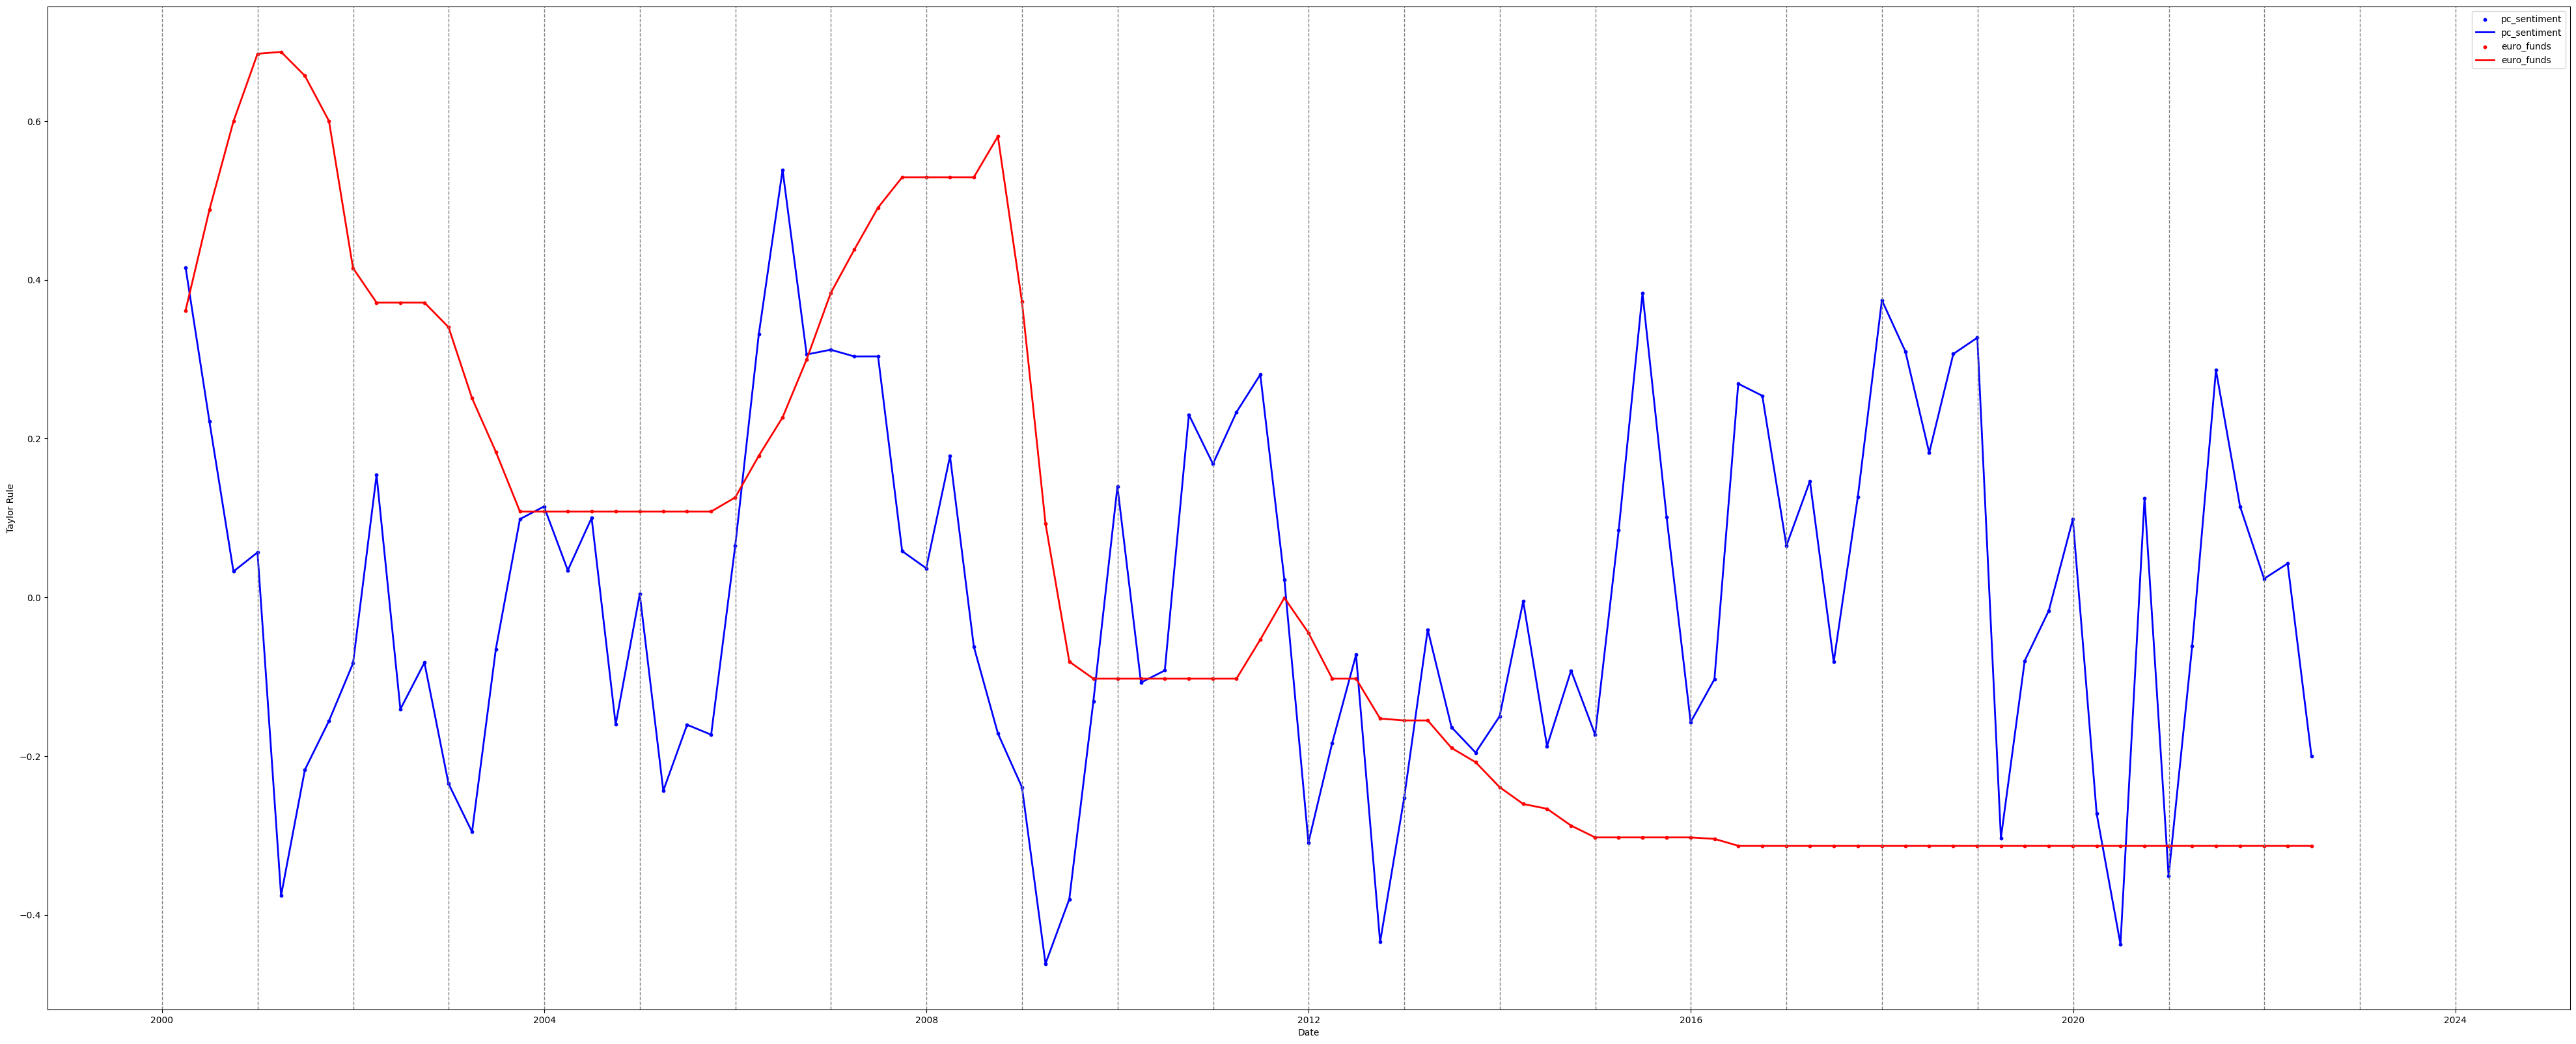

In [374]:
print(sentiment.columns)

x1 = "pc_sentiment"
x2 = "minute_sentiment"
x3 = "euro_funds"
x4 = "minute_sentiment_diff_cycle"

# Graph the Data
fig, ax = plt.subplots(figsize=(50, 20))

ax.scatter(sentiment["date"], sentiment[f"{x1}"], label=f"{x1}", color="blue", s=10)
ax.plot(sentiment["date"], sentiment[f"{x1}"], label=f"{x1}", color="blue", lw=2)

# ax.scatter(sentiment['date'], sentiment[f'{x2}'], label=f'{x2}', color='green', s=10)
# ax.plot(sentiment['date'], sentiment[f'{x2}'], label=f'{x2}', color='green', lw=1)

ax.scatter(sentiment["date"], sentiment[f"{x3}"], label=f"{x3}", color="red", s=10)
ax.plot(sentiment["date"], sentiment[f"{x3}"], label=f"{x3}", color="red", lw=2)

# ax.scatter(sentiment['date'], sentiment[f'{x4}'], label=f'{x4}', color='purple', s=10)
# ax.plot(sentiment['date'], sentiment[f'{x4}'], label=f'{x4}', color='purple')

# ax.scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black', s=10)
# ax.plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')

# ax.scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black', s=10)
# ax.plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')

# Create a vertical line at every year
for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1)

ax.set_xlabel("Date")
ax.set_ylabel("Taylor Rule")
ax.legend()
plt.show()

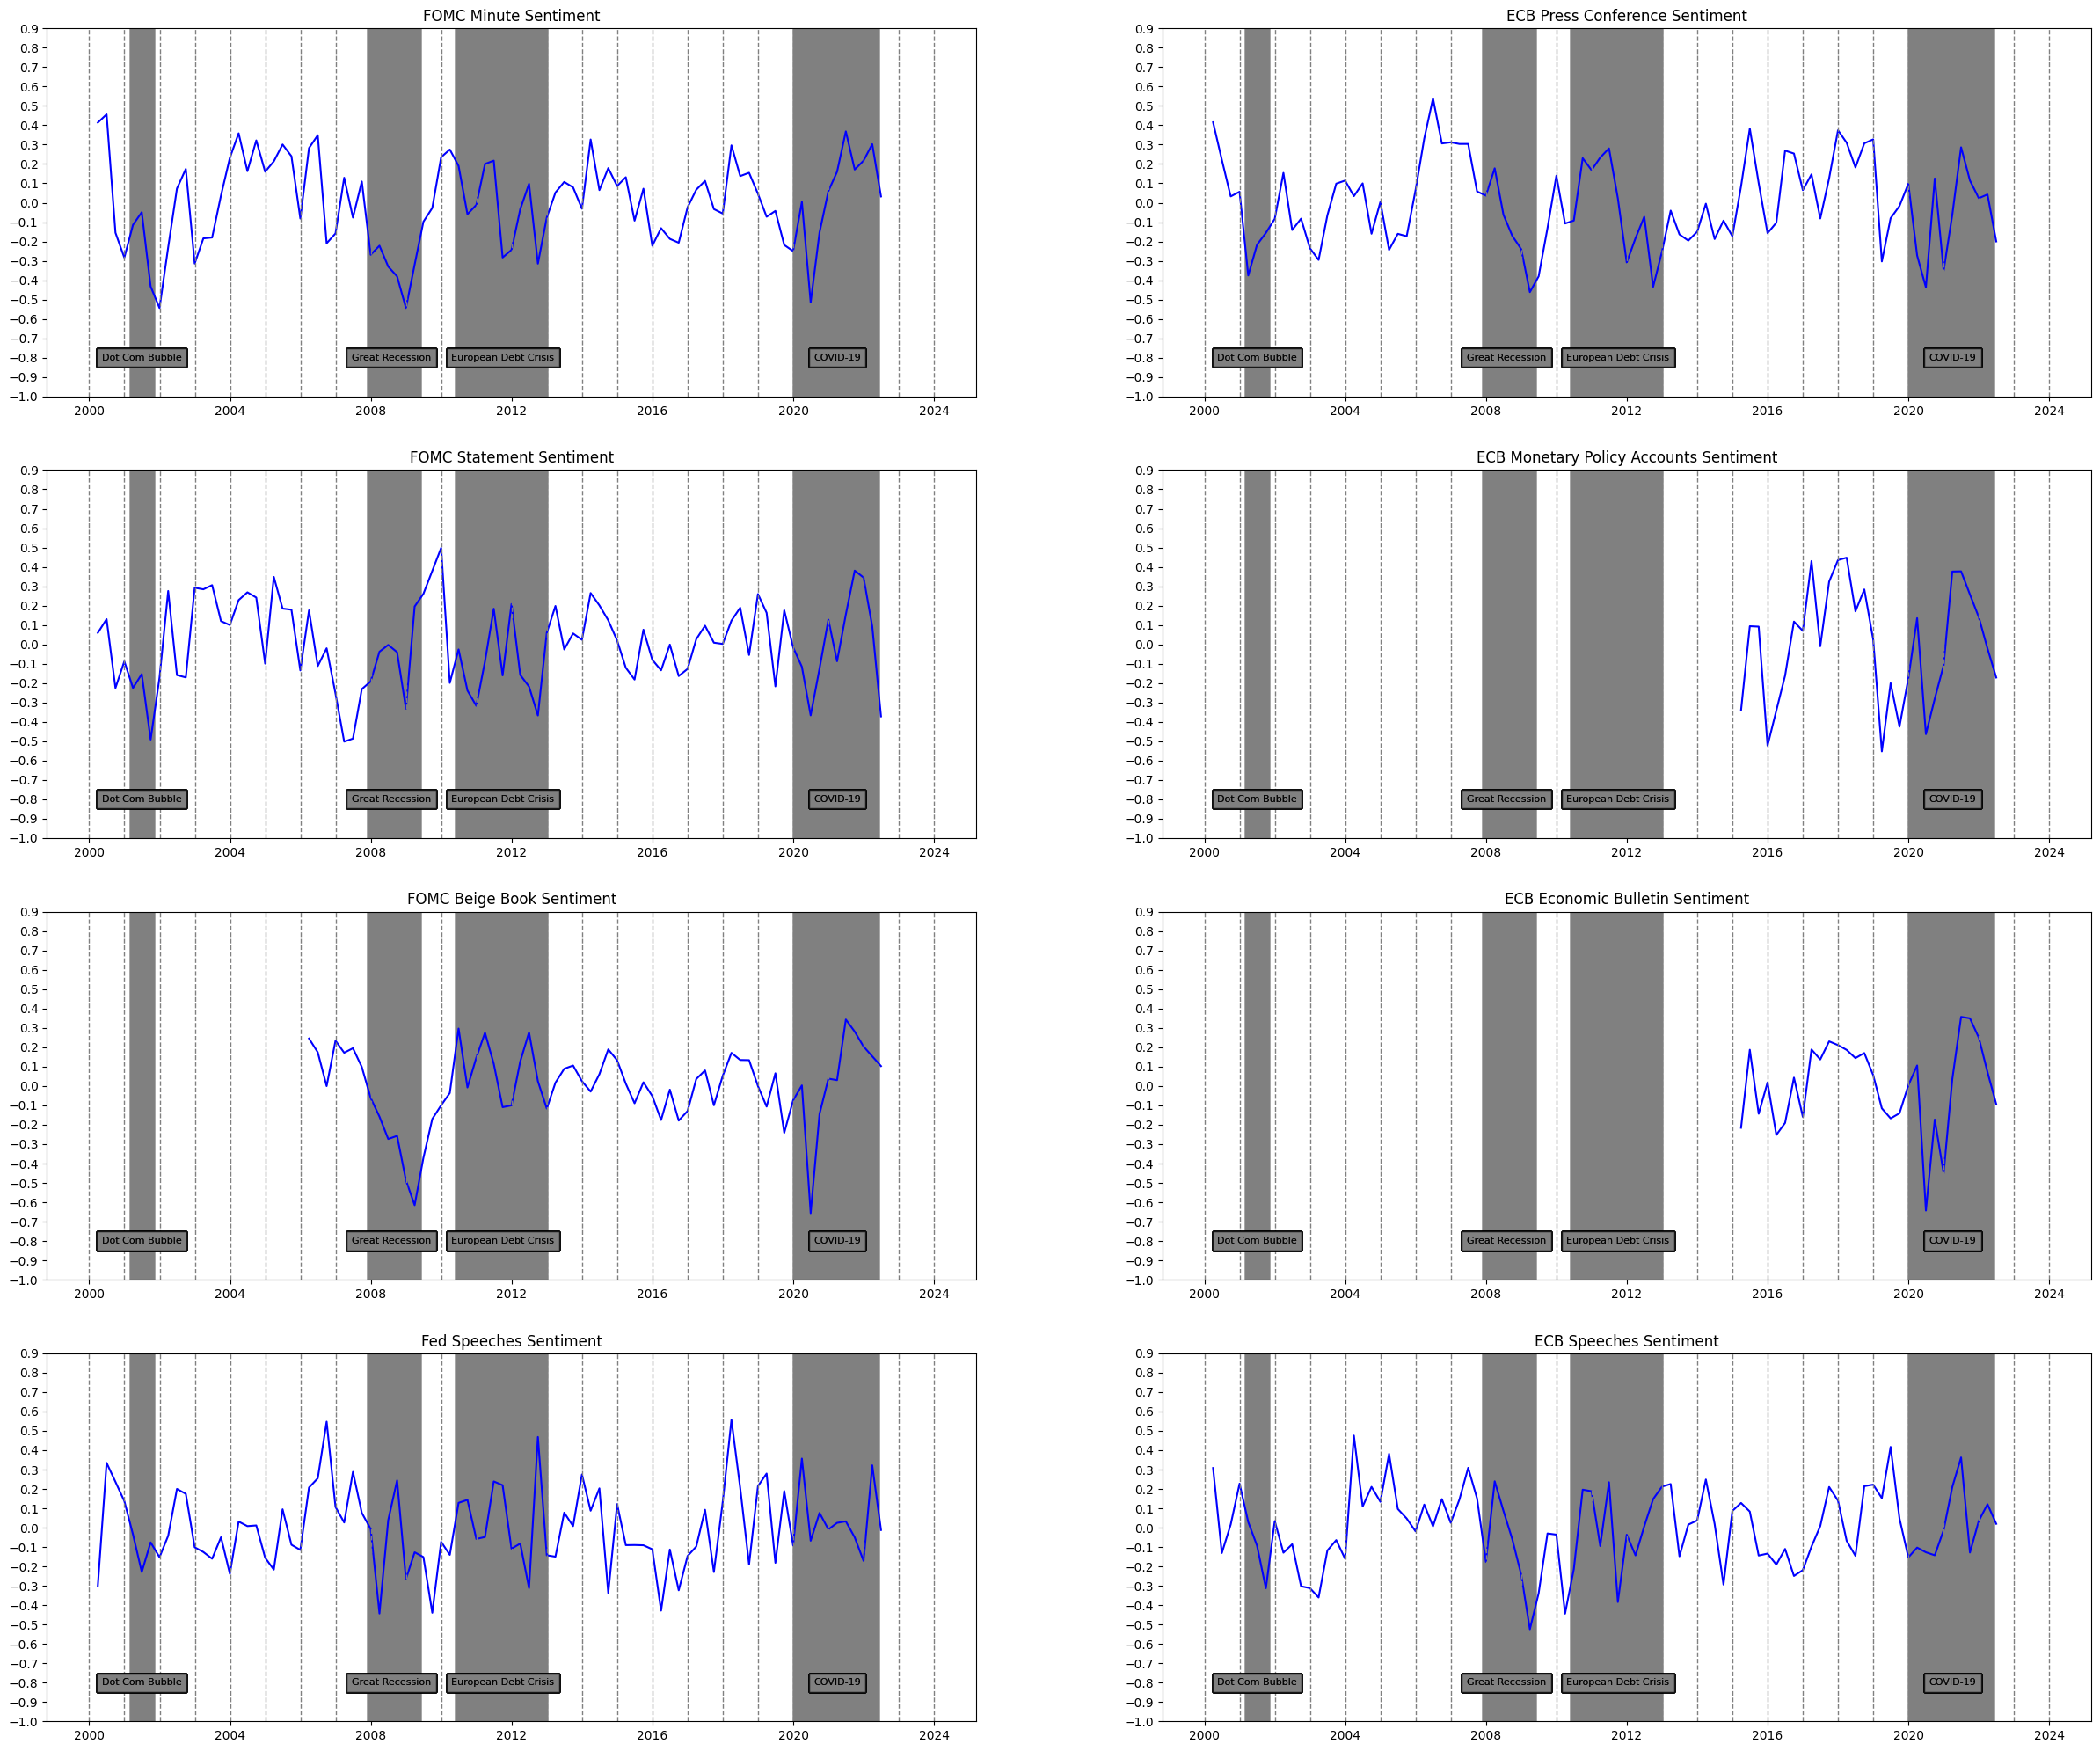

In [375]:
# recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(4, 2, figsize=(30, 25))

min = -1
max = 1

ax[0, 0].plot(
    sentiment["date"],
    sentiment["minute_sentiment"],
    label="FOMC Minute Sentiment",
    color="blue",
)

ax[0, 0].set_title("FOMC Minute Sentiment")
ax[0, 0].set_yticks(np.arange(min, max, 0.1))

ax[1, 0].plot(
    sentiment["date"],
    sentiment["statement_sentiment"],
    label="Statement Sentiment",
    color="blue",
)
ax[1, 0].set_title("FOMC Statement Sentiment")
ax[1, 0].set_yticks(np.arange(min, max, 0.1))

ax[2, 0].plot(
    sentiment["date"],
    sentiment["beigebook_sentiment"],
    label="Beige Book Sentiment",
    color="blue",
)
ax[2, 0].set_title("FOMC Beige Book Sentiment")
ax[2, 0].set_yticks(np.arange(min, max, 0.1))

ax[0, 1].plot(
    sentiment["date"],
    sentiment["pc_sentiment"],
    label="Press Conference Sentiment",
    color="blue",
)
ax[0, 1].set_title("ECB Press Conference Sentiment")
ax[0, 1].set_yticks(np.arange(min, max, 0.1))

ax[1, 1].plot(
    sentiment["date"],
    sentiment["mpd_sentiment"],
    label="Monetary Policy Accounts Sentiment",
    color="blue",
)
ax[1, 1].set_title("ECB Monetary Policy Accounts Sentiment")
ax[1, 1].set_yticks(np.arange(min, max, 0.1))

ax[2, 1].plot(
    sentiment["date"],
    sentiment["eb_sentiment"],
    label="Economic Bulletin Sentiment",
    color="blue",
)
ax[2, 1].set_title("ECB Economic Bulletin Sentiment")
ax[2, 1].set_yticks(np.arange(min, max, 0.1))

ax[3, 1].plot(
    sentiment["date"],
    sentiment["ecb_speech_sentiment"],
    label="ECB Speeches Sentiment",
    color="blue",
)
ax[3, 1].set_title("ECB Speeches Sentiment")
ax[3, 1].set_yticks(np.arange(min, max, 0.1))

ax[3, 0].plot(
    sentiment["date"],
    sentiment["fed_speech_sentiment"],
    label="Fed Speeches Sentiment",
    color="blue",
)
ax[3, 0].set_title("Fed Speeches Sentiment")
ax[3, 0].set_yticks(np.arange(min, max, 0.1))


lh = -0.8

# Create a vertical line at every year
for i in range(4):
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(
                pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1
            )

            # Great Recession
            ax[i, j].axvspan(
                pd.to_datetime("2007-12-01"),
                pd.to_datetime("2009-06-01"),
                color="gray",
                alpha=0.2,
            )
            ax[i, j].text(
                pd.to_datetime("2008-08-01"),
                lh,
                "Great Recession",
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8,
                bbox=dict(facecolor="gray", alpha=0.5),
            )

            # COVID
            ax[i, j].axvspan(
                pd.to_datetime("2020-01-01"),
                pd.to_datetime("2022-06-01"),
                color="gray",
                alpha=0.2,
            )
            ax[i, j].text(
                pd.to_datetime("2021-04-01"),
                lh,
                "COVID-19",
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8,
                bbox=dict(facecolor="gray", alpha=0.5),
            )

            # European Debt Crisis
            ax[i, j].axvspan(
                pd.to_datetime("2010-06-01"),
                pd.to_datetime("2013-01-01"),
                color="gray",
                alpha=0.2,
            )
            ax[i, j].text(
                pd.to_datetime("2011-10-01"),
                lh,
                "European Debt Crisis",
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8,
                bbox=dict(facecolor="gray", alpha=0.5),
            )

            # Dot Com Bubble
            ax[i, j].axvspan(
                pd.to_datetime("2001-03-01"),
                pd.to_datetime("2001-11-01"),
                color="gray",
                alpha=0.2,
            )
            ax[i, j].text(
                pd.to_datetime("2001-07-01"),
                lh,
                "Dot Com Bubble",
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8,
                bbox=dict(facecolor="gray", alpha=0.5),
            )

plt.show()